# library imports

In [694]:
import pandas as pd 
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kruskal
import itertools

# Load our data

In [631]:
ratings = {'Rating': [], 'Date': [], 'Resort': []}
ratings = pd.DataFrame(ratings)
for file in os.listdir('comments/'):
    filepath = os.path.join('comments/', file)
    df = pd.read_csv(filepath)
    date = df['Date']
    rating = df['Rating']
    resort = file.split('.')
    if len(resort)==2: resort = resort[0]
    else: 
        resort = resort[0]+'.'+resort[1]
    df_tmp = pd.DataFrame({
        'Rating': rating,
        'Date': date,
        'Resort': [resort]*df.shape[0]
    })
    ratings =  pd.concat([ratings, df_tmp])

In [632]:
ratings

,Rating,Date,Resort
0,4.0,2017-04-22 03:53:09,Charlotte
1,5.0,2017-06-11 03:54:51,Charlotte
2,5.0,2017-10-18 07:23:51,Charlotte
3,4.0,2017-12-04 09:57:32,Charlotte
4,4.0,2017-12-08 06:26:21,Charlotte
...,...,...,...
2635,2.0,2025-08-27 11:34:04,Thredbo
2636,4.0,2025-08-27 12:16:21,Thredbo
2637,5.0,2025-08-29 04:46:27,Thredbo
2638,5.0,2025-08-29 12:18:15,Thredbo


In [633]:
ratings = pd.DataFrame(ratings)
ratings.head()

,Rating,Date,Resort
0,4.0,2017-04-22 03:53:09,Charlotte
1,5.0,2017-06-11 03:54:51,Charlotte
2,5.0,2017-10-18 07:23:51,Charlotte
3,4.0,2017-12-04 09:57:32,Charlotte
4,4.0,2017-12-08 06:26:21,Charlotte


In [634]:
ratings['Resort'].unique()

array(['Charlotte', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller',
       'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo'],
      dtype=object)

In [635]:
ratings['Resort']=ratings['Resort'].map(lambda x: 'Charlotte Pass' if x=='Charlotte' else x)

# Data transformations

In [636]:
# These are artificial dates for the ratings
# If a rating is made at week1 in a year, it is marked to be on the first date of the week
def compute_custom_week(date):
    date = datetime.strptime(date,"%Y-%m-%d %H:%M:%S")
    week1_start = pd.to_datetime(f"{date.year}-06-09")
    days_diff = (date - week1_start).days

    week_num = (days_diff // 7) + 1

    return 'week'+str(week_num) if week_num >= 1 and week_num<=15 else None  

In [637]:
compute_custom_week(ratings['Date'].values[0])

In [638]:
ratings['Week'] = ratings['Date'].apply(lambda x:compute_custom_week(x))

In [639]:
ratings = ratings[~ratings['Week'].isnull()]

In [640]:
ratings

,Rating,Date,Resort,Week
1,5.0,2017-06-11 03:54:51,Charlotte Pass,week1
19,1.0,2018-08-19 05:10:19,Charlotte Pass,week11
20,1.0,2018-08-26 00:55:01,Charlotte Pass,week12
35,5.0,2019-06-09 11:49:33,Charlotte Pass,week1
36,5.0,2019-06-20 11:50:03,Charlotte Pass,week2
...,...,...,...,...
2635,2.0,2025-08-27 11:34:04,Thredbo,week12
2636,4.0,2025-08-27 12:16:21,Thredbo,week12
2637,5.0,2025-08-29 04:46:27,Thredbo,week12
2638,5.0,2025-08-29 12:18:15,Thredbo,week12


In [641]:
# Make Year as a feature for the ease of data processing later
ratings['Year'] = ratings['Date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)

In [642]:
ratings = ratings.groupby(['Resort','Week', 'Year'])['Rating'].mean()

In [643]:
# Generate the dataset
ratings.reset_index().to_csv('ratings.csv')

# More Analysis on the ratings
## Visualization on ratings changement

In [644]:
ratings = pd.DataFrame(ratings.reset_index())
ratings['week_num'] = ratings['Week'].apply(lambda x: int(x[-1]))
ratings = ratings.sort_values(['Resort', 'week_num', 'Year'])

In [645]:
ratings.isnull().sum()

Resort      0
Week        0
Year        0
Rating      0
week_num    0
dtype: int64

In [646]:
ratings

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.000000,0
4,Charlotte Pass,week10,2021,5.000000,0
5,Charlotte Pass,week10,2022,3.500000,0
6,Charlotte Pass,week10,2025,5.000000,0
0,Charlotte Pass,week1,2017,5.000000,1
...,...,...,...,...,...
708,Thredbo,week9,2021,3.800000,9
709,Thredbo,week9,2022,4.692308,9
710,Thredbo,week9,2023,4.625000,9
711,Thredbo,week9,2024,4.600000,9


In [647]:
ratings.dtypes

Resort       object
Week         object
Year          int64
Rating      float64
week_num      int64
dtype: object

In [648]:
ratings = ratings[ratings['Year']>2013]

In [649]:
ratings.head()

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.0,0
4,Charlotte Pass,week10,2021,5.0,0
5,Charlotte Pass,week10,2022,3.5,0
6,Charlotte Pass,week10,2025,5.0,0
0,Charlotte Pass,week1,2017,5.0,1


In [650]:
ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\2824894695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')


In [651]:
ratings.tail()

,Resort,Week,Year,Rating,week_num,Date
708,Thredbo,week9,2021,3.800000,9,2021-08-11
709,Thredbo,week9,2022,4.692308,9,2022-08-11
710,Thredbo,week9,2023,4.625000,9,2023-08-11
711,Thredbo,week9,2024,4.600000,9,2024-08-11
712,Thredbo,week9,2025,4.000000,9,2025-08-11


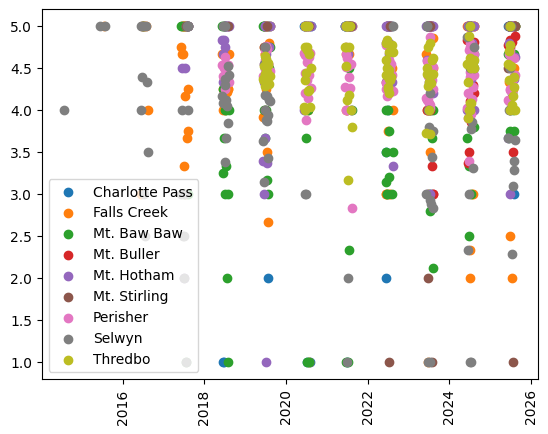

In [652]:
fig, ax= plt.subplots(1,1)
for x in ratings.Resort.unique():
    data = ratings.loc[ratings['Resort']==x]
    data = data.sort_values('Date')
    data = data.sort_values(['week_num', 'Year'])
    ax.scatter(data['Date'], data['Rating'], label = x)
plt.xticks(rotation=90)
plt.legend()

## Aggregate ratings with visitation dataset

In [653]:
visit_aus = pd.read_excel('2025 Allianz Datathon Dataset.xlsx', sheet_name='Visitation Data')

In [654]:
visit_aus = visit_aus.melt(value_vars=['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 	'Mt. Buller',  'Selwyn',
	                       'Thredbo', 'Perisher',  'Charlotte Pass'], id_vars=['Year', 'Week'])

In [655]:
visit_aus['variable'].unique()

array(['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek',
       'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass'],
      dtype=object)

In [656]:
visit_aus_mu = visit_aus.groupby(['variable', 'Week', 'Year']).value.mean().reset_index()

In [657]:
visit_aus_mu[(visit_aus_mu['variable']=='Charlotte Pass') & (visit_aus_mu['Week']==3)]

,variable,Week,Year,value
22,Charlotte Pass,3,2014,230.0
23,Charlotte Pass,3,2015,501.0
24,Charlotte Pass,3,2016,1096.0
25,Charlotte Pass,3,2017,842.0
26,Charlotte Pass,3,2018,1264.0
27,Charlotte Pass,3,2019,992.0
28,Charlotte Pass,3,2020,133.0
29,Charlotte Pass,3,2021,1307.0
30,Charlotte Pass,3,2022,2385.0
31,Charlotte Pass,3,2023,1607.0


In [658]:
ratings['week_num'] = ratings['week_num']+1
combined_visit_ratings = visit_aus_mu.merge(ratings, left_on=['variable', 'Week', 'Year'], right_on=['Resort', 'week_num', 'Year'])

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\2632842855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['week_num'] = ratings['week_num']+1


In [659]:
for x in combined_visit_ratings['Resort'].unique():
    data = combined_visit_ratings[combined_visit_ratings['Resort']==x]
    data = data.sort_values(by=['Date'])
    result = pearsonr(data['value'], data['Rating'])
    print(f'Pearson Correlation on n_visits and Ratings at resort {x} has a stats of {round(result.statistic, 3)} with pval of {round(result.pvalue, 3)}')

Pearson Correlation on n_visits and Ratings at resort Charlotte Pass has a stats of 0.015 with pval of 0.944
Pearson Correlation on n_visits and Ratings at resort Falls Creek has a stats of 0.019 with pval of 0.856
Pearson Correlation on n_visits and Ratings at resort Mt. Baw Baw has a stats of 0.003 with pval of 0.976
Pearson Correlation on n_visits and Ratings at resort Mt. Buller has a stats of 0.055 with pval of 0.812
Pearson Correlation on n_visits and Ratings at resort Mt. Hotham has a stats of 0.001 with pval of 0.993
Pearson Correlation on n_visits and Ratings at resort Mt. Stirling has a stats of -0.097 with pval of 0.731
Pearson Correlation on n_visits and Ratings at resort Perisher has a stats of 0.122 with pval of 0.228
Pearson Correlation on n_visits and Ratings at resort Selwyn has a stats of -0.18 with pval of 0.094
Pearson Correlation on n_visits and Ratings at resort Thredbo has a stats of -0.077 with pval of 0.475


In [668]:
v = visit_aus.groupby('variable')['value'].sum()

In [669]:
r = ratings.groupby('Resort')['Rating'].mean()

In [673]:
r

Resort
Charlotte Pass    3.850000
Falls Creek       4.286550
Mt. Baw Baw       3.932335
Mt. Buller        4.409056
Mt. Hotham        4.622528
Mt. Stirling      4.154762
Perisher          4.416697
Selwyn            3.823568
Thredbo           4.450554
Name: Rating, dtype: float64

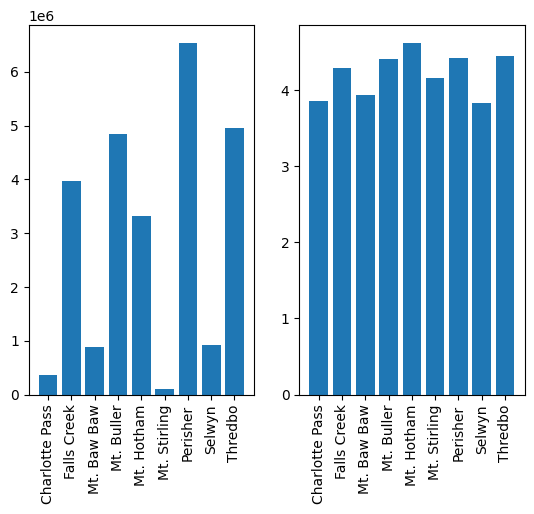

In [687]:
fig, ax = plt.subplots(1, 2)
ax[0].bar(x = v.index, height = v)
ax[0].tick_params(axis='x', labelrotation=90)
ax[1].bar(x=r.index, height = r)
ax[1].tick_params(axis='x', labelrotation=90)

In [671]:
pearsonr(v, r)

PearsonRResult(statistic=0.7786250429899373, pvalue=0.013431407051695257)

# checking how different our ratings in the fields are

In [699]:
rating_matrix = []
locs = ratings.Resort.unique()
for x in locs:
    data = ratings[ratings['Resort']==x]
    data = data.sort_values(by='Date') 
    rating_matrix.append(data['Rating'].values)

for i in itertools.combinations(range(len(rating_matrix)), 2):
    first, second = i 
    _, p_val = kruskal(rating_matrix[first], rating_matrix[second])
    if p_val<0.05: print(f'{locs[first]} and {locs[second]} have different distributions in ratings')

Falls Creek and Mt. Baw Baw have different distributions in ratings
Falls Creek and Mt. Hotham have different distributions in ratings
Falls Creek and Selwyn have different distributions in ratings
Mt. Baw Baw and Mt. Hotham have different distributions in ratings
Mt. Baw Baw and Mt. Stirling have different distributions in ratings
Mt. Baw Baw and Perisher have different distributions in ratings
Mt. Baw Baw and Thredbo have different distributions in ratings
Mt. Buller and Mt. Hotham have different distributions in ratings
Mt. Buller and Selwyn have different distributions in ratings
Mt. Hotham and Perisher have different distributions in ratings
Mt. Hotham and Selwyn have different distributions in ratings
Mt. Hotham and Thredbo have different distributions in ratings
Mt. Stirling and Perisher have different distributions in ratings
Mt. Stirling and Selwyn have different distributions in ratings
Mt. Stirling and Thredbo have different distributions in ratings
Perisher and Selwyn have 

# Web Crawling on Skii information dataset